In [21]:
import cv2  # OpenCV library
import numpy as np  # Numpy library
import dlib # Dlib library
from math import hypot  # Hypotenuse function
from heatmap import heatmap # Heatmap function

In [22]:
cap = cv2.VideoCapture(0)   # 0 for webcam

detector = dlib.get_frontal_face_detector()  # face detector

predictor = dlib.shape_predictor("shape_predictor_68_face_landmarks.dat")   # landmark detector

font = cv2.FONT_HERSHEY_PLAIN   # font for text

In [23]:
def midpoint(p1, p2):   # function to find midpoint of two points
    return int((p1.x + p2.x) / 2), int((p1.y + p2.y) /2)    # return midpoint

In [24]:
def get_eye(eye_points, facial_landmarks):  # function to find eye ratio
    left_point = (facial_landmarks.part(eye_points[0]).x, facial_landmarks.part(eye_points[0]).y)   # left point of eye
    right_point = (facial_landmarks.part(eye_points[3]).x, facial_landmarks.part(eye_points[3]).y)  # right point of eye

    center_top = midpoint(facial_landmarks.part(eye_points[1]), facial_landmarks.part(eye_points[2]))   # top center point of eye   
    center_bottom = midpoint(facial_landmarks.part(eye_points[5]), facial_landmarks.part(eye_points[4]))    # bottom center point of eye

    hor_line_length = hypot((left_point[0] - right_point[0]), (left_point[1] - right_point[1]))  # horizontal line length
    ver_line_length = hypot((center_top[0] - center_bottom[0]), (center_top[1] - center_bottom[1]))  # vertical line length

    eye_x = int((left_point[0] + right_point[0])/2)  # x coordinate of eye center
    eye_y = int((center_top[1] + center_bottom[1])/2)   # y coordinate of eye center

    cv2.circle(frame, (eye_x, eye_y), 5, (0, 0, 255), 2)    # draw circle on eye center

    ratio = hor_line_length / ver_line_length   # eye ratio

    return ratio    # return eye ratio


In [25]:
def get_gaze_ratio(eye_points,facial_landmarks):    # function to find gaze ratio
    # Gaze Detection
    eye_region = np.array([  # eye region
        (facial_landmarks.part(eye_points[0]).x, facial_landmarks.part(eye_points[0]).y),   # eye region
        (facial_landmarks.part(eye_points[1]).x, facial_landmarks.part(eye_points[1]).y),   # eye region
        (facial_landmarks.part(eye_points[2]).x, facial_landmarks.part(eye_points[2]).y),   # eye region
        (facial_landmarks.part(eye_points[3]).x, facial_landmarks.part(eye_points[3]).y),   # eye region
        (facial_landmarks.part(eye_points[4]).x, facial_landmarks.part(eye_points[4]).y),   # eye region
        (facial_landmarks.part(eye_points[5]).x, facial_landmarks.part(eye_points[5]).y)], np.int32)    # eye region

    h,w,_ = frame.shape  # height and width of frame
    mask = np.zeros((h,w), np.uint8)    # mask

    cv2.polylines(mask, [eye_region], True, 255, 2)  # draw eye region on mask
    cv2.fillPoly(mask, [eye_region], 255)   # fill eye region on mask
    eye = cv2.bitwise_and(gray, gray, mask=mask)        # bitwise and of gray and mask

    min_x = np.min(eye_region[:,0])    # minimum x coordinate of eye region
    max_x = np.max(eye_region[:,0])   # maximum x coordinate of eye region
    min_y = np.min(eye_region[:,1])  # minimum y coordinate of eye region
    max_y = np.max(eye_region[:,1]) # maximum y coordinate of eye region

    gray_eye = eye[min_y: max_y, min_x: max_x]  # gray eye
    _, threshold_eye = cv2.threshold(gray_eye, 40, 255, cv2.THRESH_BINARY)  # threshold eye
    h, w = threshold_eye.shape  # height and width of threshold eye

    left_side_threshold = threshold_eye[0:h+5, 0:int(w/2)]  # left side of threshold eye
    left_side_white = cv2.countNonZero(left_side_threshold) # count non zero pixels of left side of threshold eye
    
    right_side_threshold = threshold_eye[0:h+5, int(w/2): w]    # right side of threshold eye
    right_side_white = cv2.countNonZero(right_side_threshold)   # count non zero pixels of right side of threshold eye

    # Avoid Division by Zero
    if left_side_white <= 0:    
        left_side_white = 0.1   # if left side white is zero then make it 0.1
    if right_side_white <= 0:
        right_side_white = 0.1  # if right side white is zero then make it 0.1
    
    gaze_ratio = left_side_white/right_side_white   # gaze ratio

    return gaze_ratio  # return gaze ratio


In [26]:
counter = 0    # counter
heatmap_data = {'top_left': 0,'mid_left': 0,'down_left': 0,
                'top_center': 0,'mid_center': 0,'down_center': 0,
                'top_right': 0,'mid_right': 0,'down_right': 0}  # heatmap data

In [27]:
while True: # infinite loop
    _, frame = cap.read()   # read frame

    frame = cv2.flip(frame, 1)  # flip frame

    # Capture frame-by-frame
    ret, frame = cap.read() # read frame

    # Our operations on the frame come here
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)  # convert frame to gray

    faces = detector(gray)  # detect faces

    for face in faces:  # for each face
        x,y = face.left(), face.top()   # x and y coordinates of face
        x1, y1 = face.right(), face.bottom()    # x1 and y1 coordinates of face
        
        landmarks = predictor(gray, face)   # landmarks

        left_eye_ratio = get_eye([36,37,38,39,40,41], landmarks)    # left eye ratio
        right_eye_ratio = get_eye([42,43,44,45,46,47], landmarks)   # right eye ratio

        gaze_ratio_left_eye = get_gaze_ratio([36,37,38,39,40,41], landmarks)    # gaze ratio of left eye
        gaze_ratio_right_eye = get_gaze_ratio([42,43,44,45,46,47], landmarks)   # gaze ratio of right eye  
        gaze_ratio = (gaze_ratio_left_eye + gaze_ratio_right_eye) / 2   # average of gaze ratio of left and right eye

        if gaze_ratio < 0.3:    # if gaze ratio is less than 0.3
            cv2.putText(frame, "TOP LEFT", (50,100), font, 2, (0,0,255), 3) # display text
            cv2.circle(frame,(30,30), 3, (255,0,0), 10) # display circle
            heatmap_data['top_left'] += 1   # increment top left

        elif 0.3 < gaze_ratio < 0.8:    # if gaze ratio is between 0.3 and 0.8
            cv2.putText(frame, "MID LEFT", (50,100), font, 2, (0,0,255), 3) # display text
            cv2.circle(frame,(30,250), 3, (255,0,0), 10)    # display circle
            heatmap_data['mid_left'] += 1   # increment mid left

        elif 0.8 < gaze_ratio < 1.36:   # if gaze ratio is between 0.8 and 1.36
            cv2.putText(frame, "DOWN LEFT", (50,100), font, 2, (0,0,255), 3)
            cv2.circle(frame,(30,450), 3, (255,0,0), 10)
            heatmap_data['down_left'] += 1  # increment down left

        elif 1.36 < gaze_ratio < 1.92:  # if gaze ratio is between 1.36 and 1.92
            cv2.putText(frame, "TOP CENTER", (50,100), font, 2, (0,0,255), 3)
            cv2.circle(frame,(300,30), 3, (255,0,0), 10)
            heatmap_data['top_center'] += 1 # increment top center

        elif 1.92 < gaze_ratio < 6:     # if gaze ratio is between 1.92 and 6
            cv2.putText(frame, "MID CENTER", (50,100), font, 2, (0,0,255), 3)
            cv2.circle(frame,(300,250), 3, (255,0,0), 10)
            heatmap_data['mid_center'] += 1 # increment mid center

        elif 6 < gaze_ratio < 11:   # if gaze ratio is between 6 and 11
            cv2.putText(frame, "DOWN CENTER", (50,100), font, 2, (0,0,255), 3)
            cv2.circle(frame,(300,250), 3, (255,0,0), 10)   # display circle
            heatmap_data['down_center'] += 1    # increment down center

        elif 11 < gaze_ratio < 19:  # if gaze ratio is between 11 and 19
            cv2.putText(frame, "TOP RIGHT", (50,100), font, 2, (0,0,255), 3)
            cv2.circle(frame,(550,30), 3, (255,0,0), 10)
            heatmap_data['top_right'] += 1

        elif 19 < gaze_ratio < 56:  # if gaze ratio is between 19 and 56
            cv2.putText(frame, "MID RIGHT", (50,100), font, 2, (0,0,255), 3)
            cv2.circle(frame,(550,250), 3, (255,0,0), 10)
            heatmap_data['mid_right'] += 1  # increment mid right

        else:   # if gaze ratio is greater than 56
            cv2.putText(frame, "DOWN RIGHT", (50,100), font, 2, (0,0,255), 3)
            cv2.circle(frame,(550,450), 3, (255,0,0), 10)
            heatmap_data['down_right'] += 1 # increment down right

        cv2.putText(frame, str(gaze_ratio), (50,150), font, 2, (0,0,255), 3)    # display gaze ratio

        print(gaze_ratio)   # print gaze ratio

    cv2.imshow("Frame", frame)  # display frame

    key = cv2.waitKey(1)    # wait for 1 millisecond
    if key == 27:   
        break   # break if esc is pressed

cap.release()   # release camera
cv2.destroyAllWindows() # destroy all windows

0.2576014615685763
0.20317303469477382
0.2616822429906542
0.2616822429906542
0.28944009530292714
0.29128329297820826
0.24689521826429686
0.24180194805194805
0.7882410743530953
0.6836146272855134
0.7170748299319728
0.8011229314420804
0.7382120759547686
0.35400144196106703
0.3023255813953488
0.2707555602292444
0.3552108843537415
0.29638599105812224
0.6336162187647336
0.6535652920962198
0.6045384445913197
0.6985294117647058
0.7231914893617022
0.4022907900888265
0.35175757575757577
0.32280883367839885
0.3284272717766391
0.34530651340996166
0.3185648452929559
0.33445512820512824
0.3651212832550861
0.6971153846153846
0.7592307692307692
0.7170047235343151
0.7173727000427899
0.9007002801120448
0.9091118269673263
0.762643454580821
0.7851119894598155
0.9074074074074074
0.8602624179943767
0.8427724955215654
0.8305633498812863
0.7803571428571429
0.87017841971113
0.8663063909774436
0.875
1.1242717436537661
1.2856280193236715
1.2785223367697593
1.3198743575099943
1.389487870619946
1.1859492988133764

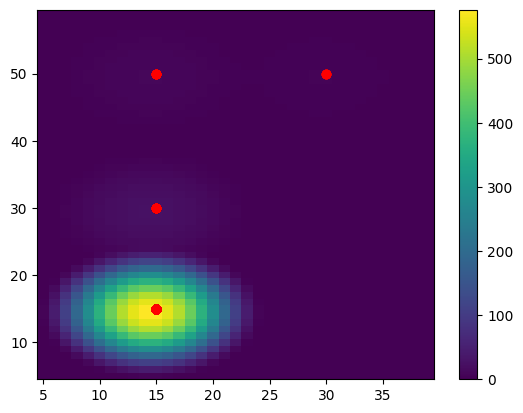

{'top_left': 10,
 'mid_left': 27,
 'down_left': 621,
 'top_center': 5,
 'mid_center': 0,
 'down_center': 0,
 'top_right': 0,
 'mid_right': 0,
 'down_right': 0}

In [28]:
heatmap(heatmap_data)   # display heatmap

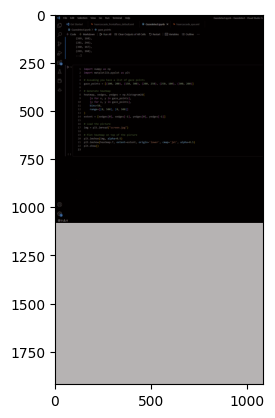

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

# Load the screenshot image
screenshot = Image.open("D:\OneDrive - jainuniversity.ac.in\D Drive\Study\PCL\Final Report\Gazedetect\Screenshot 2023-02-04 070554.png")

# Define the size of the heatmap and initialize with zeros
heatmap_size = (screenshot.width, screenshot.height)
heatmap = np.zeros(heatmap_size)

# Read the gaze points from the file (assuming each line is in the format "x,y")
with open("gaze_points.txt", "r") as f:
    for line in f:
        x, y = map(int, line.strip().split(","))
        # Increase the heatmap value at the gaze point location
        heatmap[x, y] += 1

# Normalize the heatmap values to [0, 1] range
heatmap /= np.max(heatmap)

# Plot the heatmap on top of the screenshot image
fig, ax = plt.subplots()
ax.imshow(screenshot)
ax.imshow(heatmap, cmap="hot", alpha=0.3)
plt.show()

In [2]:
import numpy as np
import pyautogui
import cv2

# Define the size of the heatmap (in pixels)
heatmap_size = (1920, 1080)

# Define the smoothing kernel size (in pixels)
kernel_size = (51, 51)

# Define the scaling factor for the heatmap
scale_factor = 255 / kernel_size[0] / kernel_size[1]

# Create an empty heatmap
heatmap = np.zeros(heatmap_size)

# Open the output file for writing gaze points
with open("gaze_points.txt", "w") as f:

    # Continuously read the current mouse position and update the heatmap
    while True:
        # Get the current mouse position
        x, y = pyautogui.position()

        # Add a Gaussian kernel centered at the current mouse position to the heatmap
        kernel = cv2.getGaussianKernel(kernel_size[0], -1)
        kernel = np.outer(kernel, kernel.transpose())
        heatmap[y:y+kernel_size[1], x:x+kernel_size[0]] += kernel
        heatmap = np.clip(heatmap, 0, 255)

        # Scale the heatmap and convert it to uint8 for display
        heatmap_scaled = (heatmap * scale_factor).astype(np.uint8)

        # Display the heatmap
        cv2.imshow("Heatmap", heatmap_scaled)
        cv2.waitKey(1)

        # Write the gaze point to the output file
        f.write(f"{x},{y}\n")
        

ValueError: operands could not be broadcast together with shapes (51,39) (51,51) (51,39) 